In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [4]:
import urllib.request
url = "https://raw.githubusercontent.com/YuhengHou/MLMA/main/Utils/EasyData.py"
urllib.request.urlretrieve(url, "EasyData.py")

('EasyData.py', <http.client.HTTPMessage at 0x78d9927e09d0>)

In [96]:
import torch
import warnings
import importlib
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
from EasyData import EasyData
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [90]:
#Load Embedding
embed = torch.load("/content/drive/MyDrive/models/esm2_delta_embeddings.pt") # embed = torch.load("/content/drive/MyDrive/models/esm2_embeddings.pt")
X, y = embed['X'], embed['y']

if not isinstance(X, np.ndarray): #to np arr
    X = X.cpu().numpy()
    y = y.cpu().numpy()

In [91]:
pipline = EasyData(embedding=X)
final_dataset = pipline.prepare_data()

In [100]:
def report_score(model, dataset, to_numeric = False):
  input = dataset.copy()
  for col in input.select_dtypes(include='object').columns:
      input[col] = pd.factorize(input[col])[0]
      input[col] = input[col].astype("category")

  input["Mapped Cancer Stage"] = input["Mapped Cancer Stage"].astype("int")
  input["Mapped Cancer Stage"] = input["Mapped Cancer Stage"] - 1

  df_split = pipline.stratified_splitting(full_dataset = input, random_state=42)
  X_train = df_split["train"].drop(columns=["Mapped Cancer Stage"])
  y_train = df_split["train"]["Mapped Cancer Stage"]
  model.fit(X_train, y_train)

  X_val = df_split["val"].drop(columns=["Mapped Cancer Stage"])
  y_val = df_split["val"]["Mapped Cancer Stage"]
  y_pred = model.predict(X_val)

  acc = accuracy_score(y_val, y_pred)
  print(f"ACC of val: {acc:.4f}")

  X_test = df_split["test"].drop(columns=["Mapped Cancer Stage"])
  y_test = df_split["test"]["Mapped Cancer Stage"]

  y_pred = model.predict(X_test)

  # Classification report
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred, digits=4))

  return acc

In [107]:
def plot_model_comparison(results):
    labels = list(results.keys())  # ['a1', 'a2', 'a3']
    lightgbm_scores = [results[key]['LightGBM'] for key in labels]
    xgboost_scores = [results[key]['XGBoost'] for key in labels]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    rects1 = ax.bar(x - width/2, lightgbm_scores, width, label='LightGBM', color='#FFB347')
    rects2 = ax.bar(x + width/2, xgboost_scores, width, label='XGBoost', color='#FFD700')

    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracy Comparison on Different Input Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.05)
    ax.legend(loc='lower right')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [71]:
LGB_model = LGBMClassifier(verbose=-1, num_class = 4)
XGB_model = XGBClassifier(objective='multi:softprob', num_class=4,eval_metric='mlogloss',use_label_encoder=False,random_state=42)

In [108]:
results = {'a1': {}, 'a2': {}, 'a3': {}}
print("Performance of a1 - LightGBM")
acc = report_score(model=LGB_model, dataset=final_dataset["a1"], to_numeric=False)
results['a1']['LightGBM'] = acc

# a1
print("Performance of a1 - XGBoost")
acc = report_score(model = XGB_model, dataset = final_dataset["a1"], to_numeric = False)
results['a1']['XGBoost'] = acc

# a2
print("Performance of a2 - LightGBM")
acc = report_score(model=LGB_model, dataset=final_dataset["a2"], to_numeric=True)
results['a2']['LightGBM'] = acc

print("Performance of a2 - XGBoost")
acc = report_score(model=XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42, enable_categorical=True), dataset=final_dataset["a2"], to_numeric=True)
results['a2']['XGBoost'] = acc

# a3
print("Performance of a3 - LightGBM")
acc = report_score(model=LGB_model, dataset=final_dataset["a3"], to_numeric=True)
results['a3']['LightGBM'] = acc

print("Performance of a3 - XGBoost")
acc = report_score(model=XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42, enable_categorical=True), dataset=final_dataset["a3"], to_numeric=True)
results['a3']['XGBoost'] = acc

Performance of a1 - LightGBM
ACC of val: 0.8686

Classification Report:
              precision    recall  f1-score   support

           0     0.8644    0.9996    0.9271      5115
           1     0.9846    0.2783    0.4339       460
           2     1.0000    0.2691    0.4240       643

    accuracy                         0.8707      6218
   macro avg     0.9497    0.5156    0.5950      6218
weighted avg     0.8873    0.8707    0.8386      6218

Performance of a1 - XGBoost
ACC of val: 0.8931

Classification Report:
              precision    recall  f1-score   support

           0     0.8907    0.9994    0.9420      5115
           1     0.9897    0.4196    0.5893       460
           2     0.9930    0.4386    0.6084       643

    accuracy                         0.8985      6218
   macro avg     0.9578    0.6192    0.7132      6218
weighted avg     0.9086    0.8985    0.8814      6218

Performance of a2 - LightGBM
ACC of val: 0.9256

Classification Report:
              precision

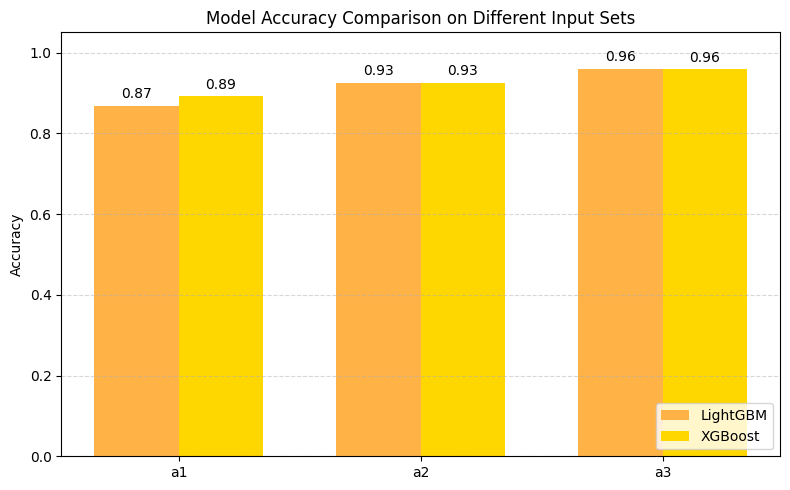

In [106]:
plot_model_comparison(results)